## 1. Import Requirements

In [105]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split

np.random.seed(5)


## 2. Loading the Dataset and Preprocessing

##### 2.a Establish Important Variables

In [13]:
train_dir = 'asl_alphabet_train/asl_alphabet_train'
test_dir = 'asl_alphabet_test/asl_alphabet_test'
img_size = 64

##### 2.b Function for parsing the images into a vector 

In [124]:
label_mapping = {
    'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6,
    'H': 7, 'I': 8, 'J': 9, 'K': 10, 'L': 11, 'M': 12, 'N': 13,
    'O': 14, 'P': 15, 'Q': 16, 'R': 17, 'S': 18, 'T': 19, 'U': 20,
    'V': 21, 'W': 22, 'X': 23, 'Y': 24, 'Z': 25,
    'nothing': 26, 'space': 27, 'del': 28
}

# responsible for parsing the images to vectors
def load_images_from_folder(folder):
    images = []
    labels = []

    for label in os.listdir(folder):
        print("Parsing label: " + label)
        label_folder = os.path.join(folder, label)
        if os.path.isdir(label_folder) and label in label_mapping:
            label_index = label_mapping[label]
            img_files = os.listdir(label_folder)

            for i, img_file in enumerate(img_files):
                if i % 2 != 0:
                    continue

                img_path = os.path.join(label_folder, img_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
                    img_resized = cv2.resize(img_gray, (img_size, img_size))  # Resize to a fixed size
                    images.append(img_resized.flatten())  # Flatten the image
                    labels.append(label_index)  # Use the mapped index for the label

    return np.array(images), np.array(labels)

# converts a given y value to the recorresponding label
def find_label_of_int(value):
    dict = { 26: "nothing", 27: "space", 28: "del" }

    if 0 <= value <= 25:
        return chr(value + ord('A'))  # Convert 0-25 to 'A'-'Z'
    elif value <= 28:
        return dict[value]

##### 2.c Parse the images and split to train and validation

In [139]:
x_train, y_train = load_images_from_folder(train_dir)

Parsing label: A
Parsing label: B
Parsing label: C
Parsing label: D
Parsing label: del
Parsing label: E
Parsing label: F
Parsing label: G
Parsing label: H
Parsing label: I
Parsing label: J
Parsing label: K
Parsing label: L
Parsing label: M
Parsing label: N
Parsing label: nothing
Parsing label: O
Parsing label: P
Parsing label: Q
Parsing label: R
Parsing label: S
Parsing label: space
Parsing label: T
Parsing label: U
Parsing label: V
Parsing label: W
Parsing label: X
Parsing label: Y
Parsing label: Z


In [140]:
print("X Train Shape: ", x_train.shape)
print("Y Train Shape: ", y_train.shape)


X Train Shape:  (43504, 4096)
Y Train Shape:  (43504,)


In [141]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

In [142]:
print("X Train Shape: ", x_train.shape)
print("Y Train Shape: ", y_train.shape)
print("X Val Shape: ", x_val.shape)
print("Y Val Shape: ", y_val.shape)

X Train Shape:  (34803, 4096)
Y Train Shape:  (34803,)
X Val Shape:  (8701, 4096)
Y Val Shape:  (8701,)


##### 2.d visualize and examine the dataset

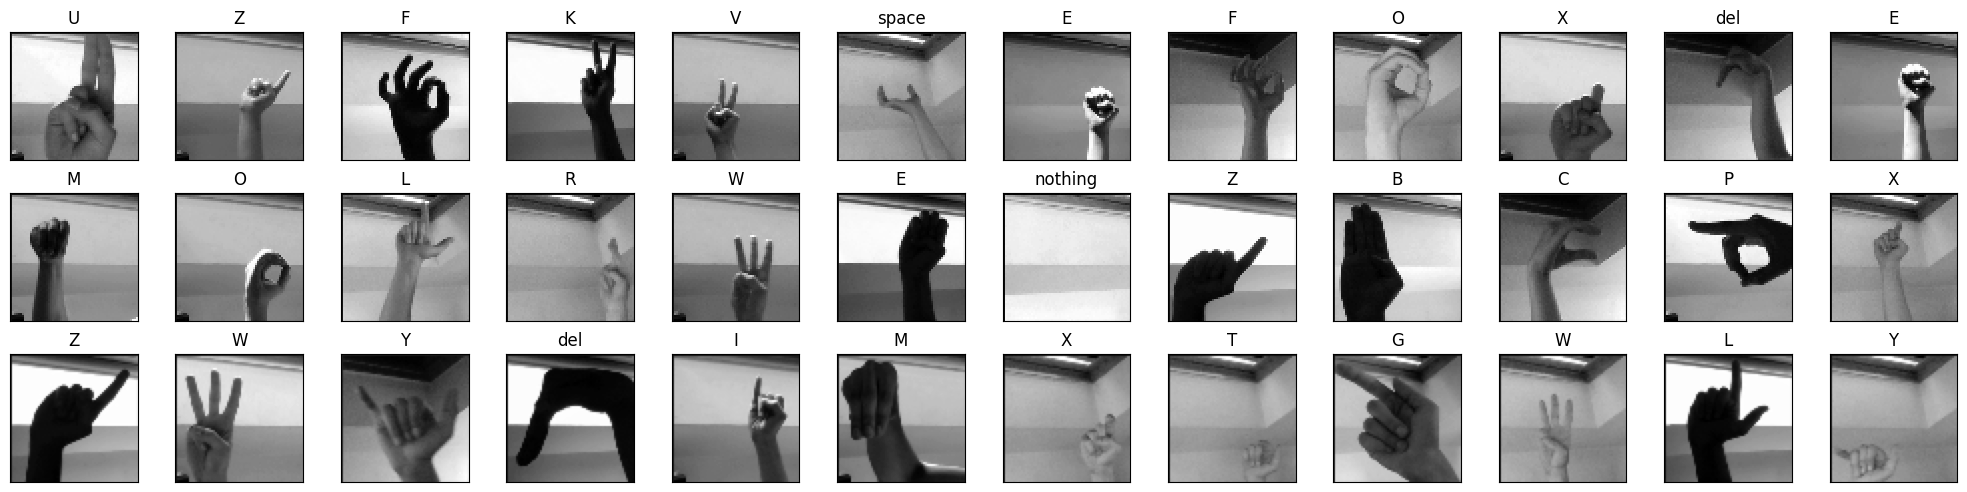

In [143]:
# Store labels of dataset
labels = ['nothing', 'space', 'del'] + [chr(i) for i in range(ord('A'), ord('Z') + 1)]

# Print the first several training images, along with the labels
fig = plt.figure(figsize=(20, 5))
for i in range(36):  # Display first 36 images
    ax = fig.add_subplot(3, 12, i + 1, xticks=[], yticks=[])
    
    # Reshape the flattened image back to (img_size, img_size)
    img_reshaped = x_train[i].reshape(img_size, img_size)
    
    ax.imshow(img_reshaped, cmap='gray')  # Display in grayscale
    ax.set_title("{}".format(find_label_of_int(y_train[i])))

plt.tight_layout()
plt.show()

Check if balanced

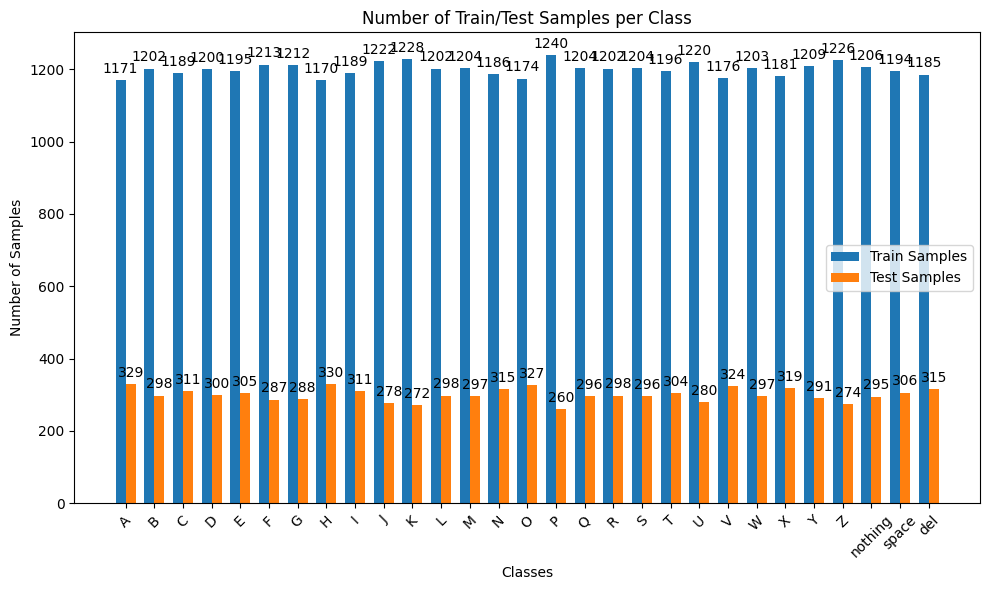

In [144]:
train_counts = [sum(y_train == i) for i in range(len(label_mapping))]
test_counts = [sum(y_val == i) for i in range(len(label_mapping))]
labels = list(label_mapping.keys())

# Set up bar positions and width
x = np.arange(len(labels))  # Label locations
width = 0.35  # Width of the bars

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
train_bars = ax.bar(x - width/2, train_counts, width, label='Train Samples')
test_bars = ax.bar(x + width/2, test_counts, width, label='Test Samples')

# Add labels, title, and legend
ax.set_xlabel('Classes')
ax.set_ylabel('Number of Samples')
ax.set_title('Number of Train/Test Samples per Class')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

# Annotate bars with counts
for bar in train_bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')

for bar in test_bars:
    height = bar.get_height()
    ax.annotate(f'{height}',
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 3. Training using different techniques

Initialize the models

In [20]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Support Vector Machine": SVC(random_state=42),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier()
}

Train each model

In [145]:
# Decision Trees
print("Training: ", "Decision Tree")
models["Decision Tree"].fit(x_train, y_train)

Training:  Decision Tree


DecisionTreeClassifier(random_state=42)

In [146]:
# Random Forest
print("Training: ", "Random Forest")
models["Random Forest"].fit(x_train, y_train)

Training:  Random Forest


RandomForestClassifier(random_state=42)

In [23]:
# K-Nearest Neighbors
print("Training: ", "K-Nearest Neighbors")
models["K-Nearest Neighbors"].fit(x_train, y_train)

Training:  K-Nearest Neighbors


KNeighborsClassifier()

In [24]:
# Naive Bayes
print("Training: ", "Naive Bayes")
models["Naive Bayes"].fit(x_train, y_train)

Training:  Naive Bayes


GaussianNB()

In [32]:
# Support Vector Machine
print("Training: ", "Support Vector Machine")
models["Support Vector Machine"].fit(x_train, y_train)

Training:  Support Vector Machine


SVC(random_state=42)

In [33]:
# Logistic Regression
print("Training: ", "Logistic Regression")
models["Logistic Regression"].fit(x_train, y_train)

Training:  Logistic Regression


C:\Users\ron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=1000, random_state=42)

Predict and produce a confusion matrix for each model

In [151]:
confusion_matrices = {}
predictions = {}

for model_name, model in models.items():
    y_pred = model.predict(x_val)
    cm = confusion_matrix(y_val, y_pred)
    confusion_matrices[model_name] = cm
    predictions[model_name] = y_pred

Plot

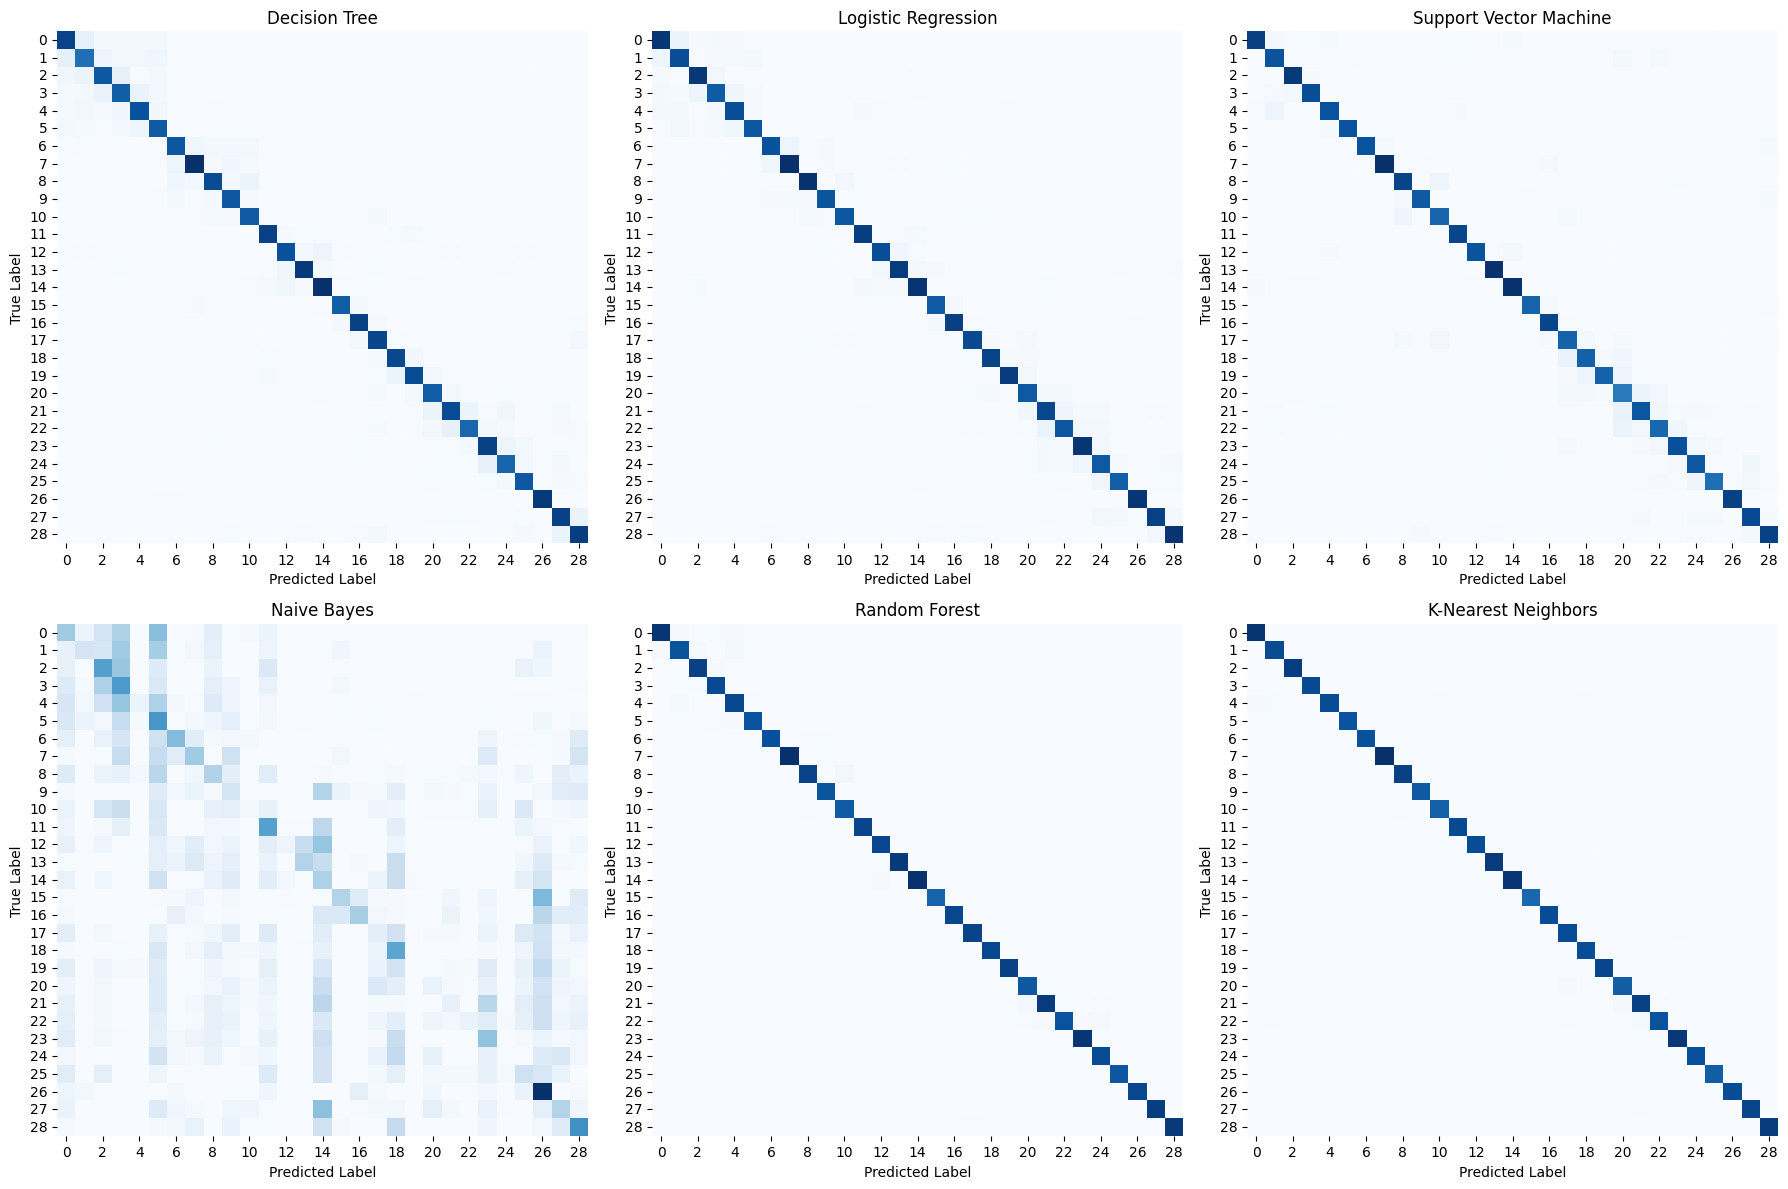

In [152]:
# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust grid size as needed
axes = axes.ravel()  # Flatten the array for easy indexing

for i, (model_name, cm) in enumerate(confusion_matrices.items()):
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"{model_name}")
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Summarize the finding

In [155]:
summary = []
for model_name, model in models.items():
    # Assuming predictions is a dictionary where each model's predictions are stored
    y_pred = predictions[model_name]
    
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred, average='weighted')  # or 'macro' depending on your needs
    recall = recall_score(y_val, y_pred, average='weighted')  # or 'macro'
    f1 = f1_score(y_val, y_pred, average='weighted')  # or 'macro'

    summary.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

In [156]:
summary_df = pd.DataFrame(summary)
print("\nSummary of Model Performance:")
print(summary_df)


Summary of Model Performance:
                    Model  Accuracy  Precision    Recall  F1 Score
0           Decision Tree  0.870245   0.870359  0.870245  0.870066
1     Logistic Regression  0.911619   0.911722  0.911619  0.911584
2  Support Vector Machine  0.922767   0.924131  0.922767  0.923011
3             Naive Bayes  0.216527   0.268469  0.216527  0.195282
4           Random Forest  0.981152   0.981265  0.981152  0.981138
5     K-Nearest Neighbors  0.990231   0.990282  0.990231  0.990229


## 4. Test on custom Data

Vectorize Test Data

In [157]:
x_test, y_test = load_images_from_folder(test_dir)

Parsing label: A
Parsing label: B
Parsing label: C
Parsing label: D
Parsing label: del
Parsing label: E
Parsing label: F
Parsing label: G
Parsing label: H
Parsing label: I
Parsing label: J
Parsing label: K
Parsing label: L
Parsing label: M
Parsing label: N
Parsing label: nothing
Parsing label: O
Parsing label: P
Parsing label: Q
Parsing label: R
Parsing label: S
Parsing label: space
Parsing label: T
Parsing label: U
Parsing label: V
Parsing label: W
Parsing label: X
Parsing label: Y
Parsing label: Z


Examine

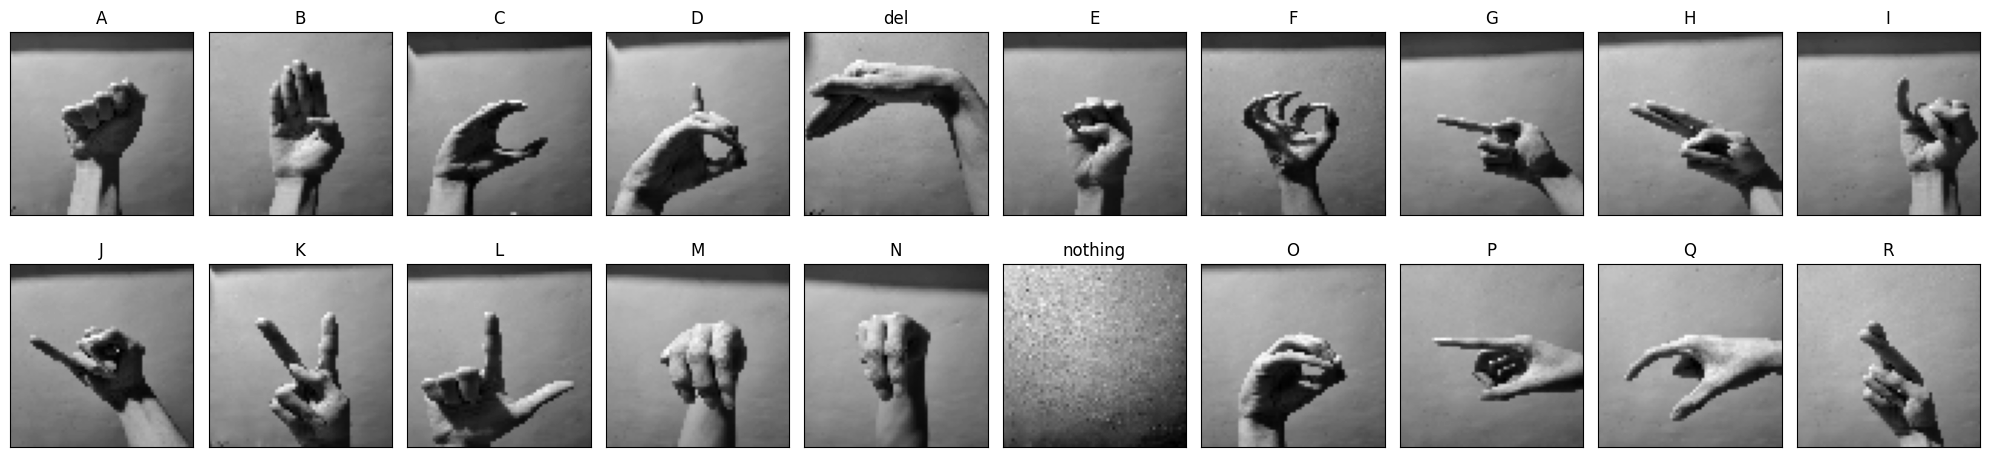

In [161]:
fig = plt.figure(figsize=(20, 5))
num_classes = 29  # Total number of classes (folders)
images_to_display = min(num_classes, 20)  # Limit to 20 images or the number of classes, whichever is smaller

displayed_classes = set()  # Track classes already displayed
class_count = 0  # Counter for displayed classes

for idx, (img, label) in enumerate(zip(x_test, y_test)):
    if label not in displayed_classes:
        displayed_classes.add(label)
        
        # Plotting the first image of each class
        ax = fig.add_subplot(2, 10, class_count + 1, xticks=[], yticks=[])
        img_reshaped = img.reshape(img_size, img_size)  # Reshape if images are flattened
        ax.imshow(img_reshaped, cmap='gray')
        ax.set_title("{}".format(find_label_of_int(label)))

        class_count += 1
        
        # Stop after displaying the specified number of classes
        if class_count == images_to_display:
            break

plt.tight_layout()
plt.show()

Produce predictions

In [162]:
confusion_matrices_test = {}
predictions_test = {}

for model_name, model in models.items():
    y_pred = model.predict(x_test)
    cm = confusion_matrix(y_test, y_pred)
    confusion_matrices_test[model_name] = cm
    predictions_test[model_name] = y_pred

Visualize results

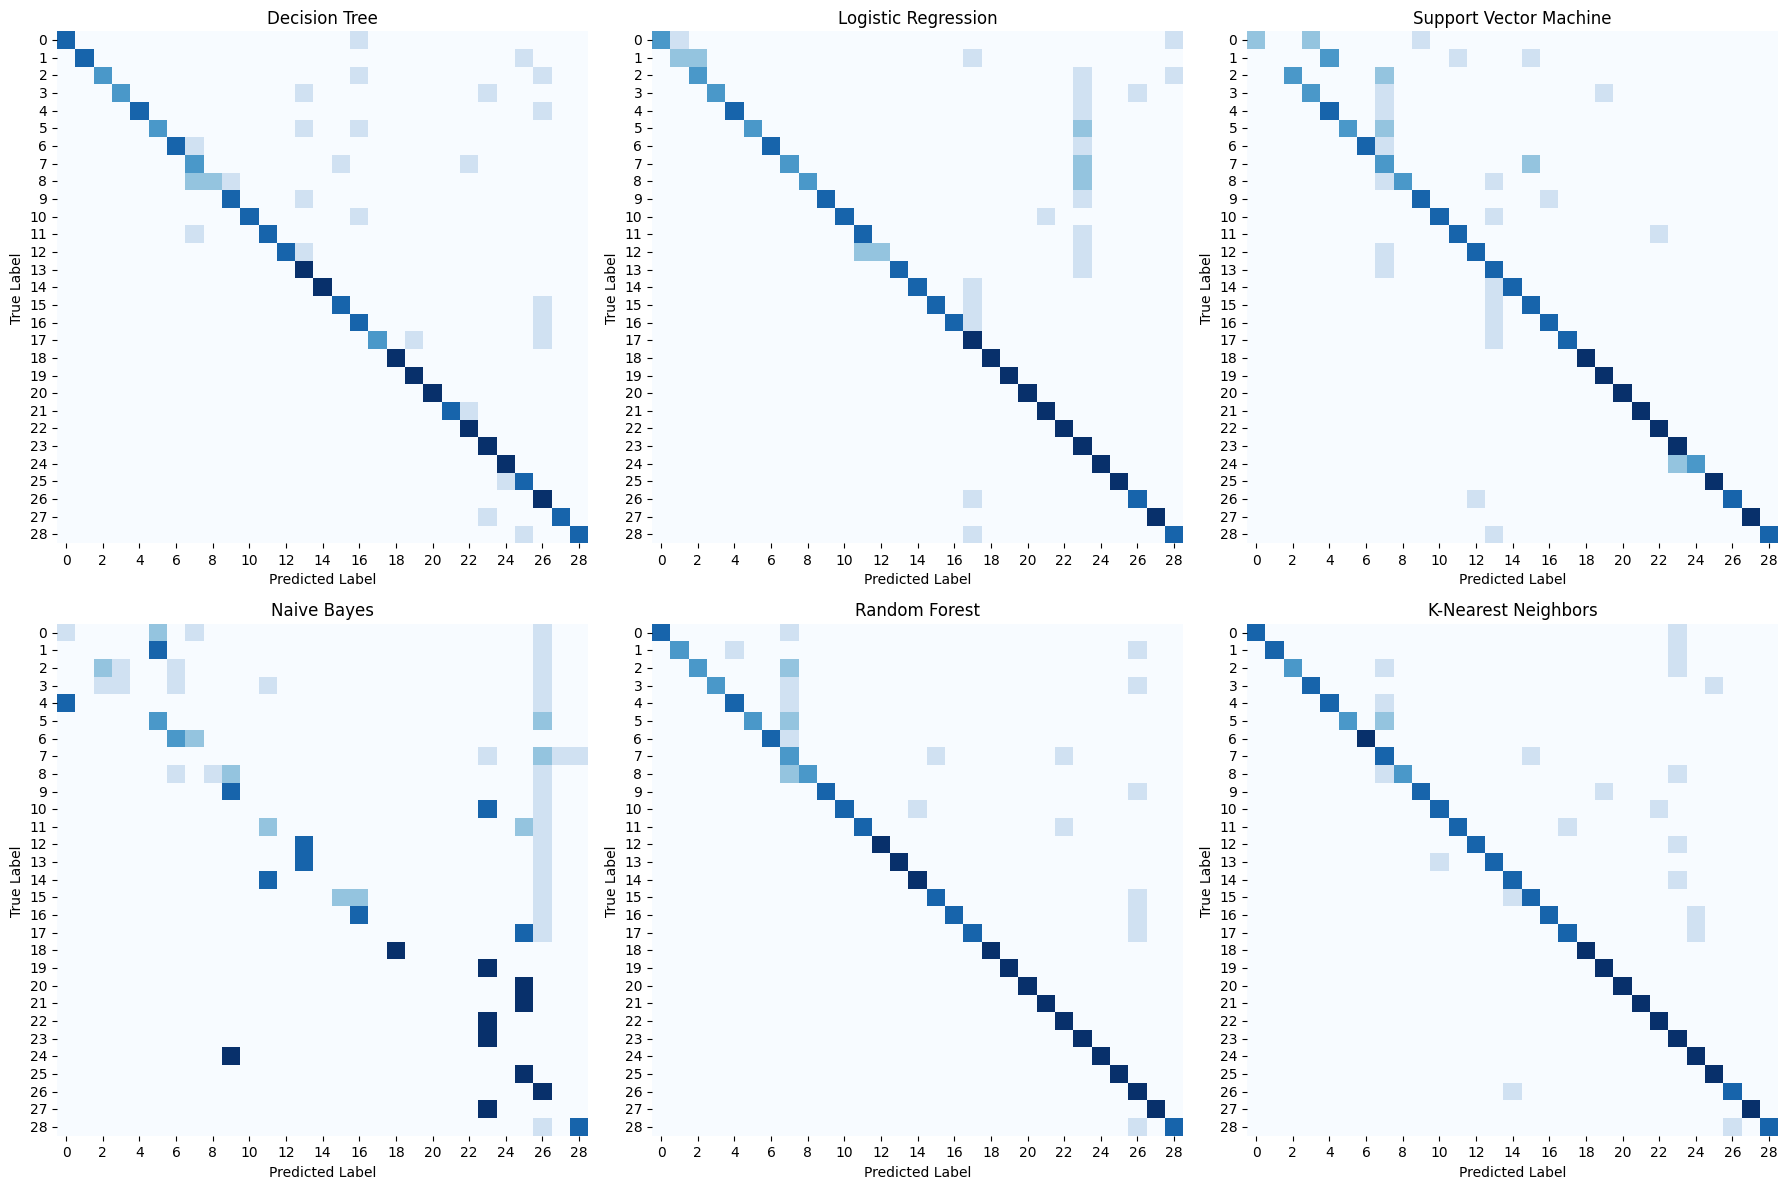

In [163]:
# Plotting
fig, axes = plt.subplots(2, 3, figsize=(18, 12))  # Adjust grid size as needed
axes = axes.ravel()  # Flatten the array for easy indexing

for i, (model_name, cm) in enumerate(confusion_matrices_test.items()):
    sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', ax=axes[i], cbar=False)
    axes[i].set_title(f"{model_name}")
    axes[i].set_xlabel('Predicted Label')
    axes[i].set_ylabel('True Label')

plt.tight_layout()
plt.show()

Summarize Results

In [164]:
summary = []
for model_name, model in models.items():
    # Assuming predictions is a dictionary where each model's predictions are stored
    y_pred = predictions_test[model_name]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')  # or 'macro' depending on your needs
    recall = recall_score(y_test, y_pred, average='weighted')  # or 'macro'
    f1 = f1_score(y_test, y_pred, average='weighted')  # or 'macro'

    summary.append({
        "Model": model_name,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    })

C:\Users\ron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [165]:
summary_df = pd.DataFrame(summary)
print("\nSummary of Model Performance:")
print(summary_df)


Summary of Model Performance:
                    Model  Accuracy  Precision    Recall  F1 Score
0           Decision Tree  0.813793   0.874001  0.813793  0.819613
1     Logistic Regression  0.800000   0.894863  0.800000  0.818546
2  Support Vector Machine  0.772414   0.824766  0.772414  0.776653
3             Naive Bayes  0.351724   0.291521  0.351724  0.272130
4           Random Forest  0.848276   0.923967  0.848276  0.866383
5     K-Nearest Neighbors  0.848276   0.895860  0.848276  0.855972


## 5. Improve

In [106]:

# Define hyperparameters to tune    
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}

In [107]:
rf_model = RandomForestClassifier(random_state=42)

In [108]:
# Use GridSearchCV to find the best hyperparameters
random_search = RandomizedSearchCV(
    estimator= rf_model,
    param_distributions=param_dist,
    n_iter=50,  # Number of parameter settings to sample
    scoring='accuracy',  # Change to your desired metric
    cv=3,  # Number of cross-validation folds
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

In [111]:
random_search.fit(x_train, y_train) 
best_rf_model = random_search.best_estimator_
predictions = best_rf_model.predict(x_val)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


C:\Users\ron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
48 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
26 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ron\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\

In [114]:
# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_val, predictions))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       584
           1       0.99      0.98      0.98       574
           2       0.99      0.99      0.99       617
           3       0.99      0.99      0.99       589
           4       0.98      0.99      0.99       580
           5       0.99      1.00      1.00       585
           6       1.00      1.00      1.00       587
           7       1.00      1.00      1.00       599
           8       0.98      0.99      0.99       598
           9       1.00      0.99      0.99       610
          10       1.00      0.99      0.99       609
          11       0.99      1.00      1.00       641
          12       0.99      0.99      0.99       626
          13       1.00      1.00      1.00       587
          14       0.99      0.99      0.99       569
          15       1.00      1.00      1.00       603
          16       1.00      0.99      1.00       586
   

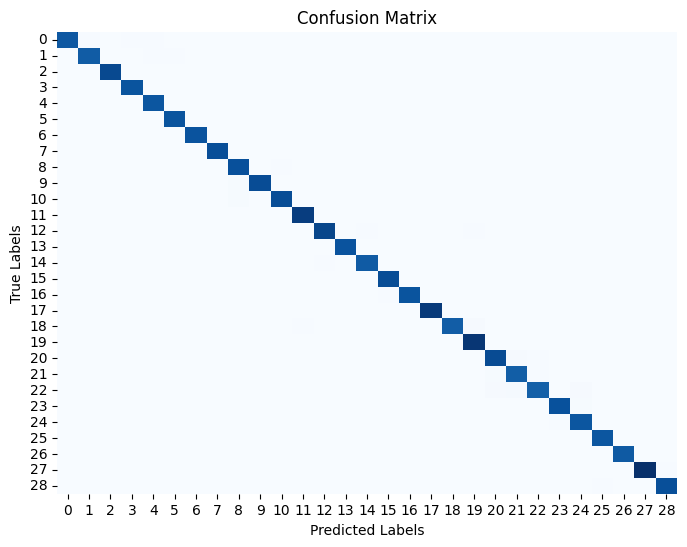

In [120]:
conf_matrix = confusion_matrix(y_val, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

## Testing On Custom Data

In [121]:
predictions_test = best_rf_model.predict(x_test)

In [122]:
# Print classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(y_test, predictions_test))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.90      0.95        10
           1       1.00      0.90      0.95        10
           2       1.00      0.70      0.82        10
           3       1.00      0.70      0.82        10
           4       1.00      0.80      0.89        10
           5       1.00      0.70      0.82        10
           6       1.00      0.80      0.89        10
           7       0.28      0.70      0.40        10
           8       1.00      0.60      0.75        10
           9       0.90      0.90      0.90        10
          10       0.89      0.80      0.84        10
          11       1.00      0.80      0.89        10
          12       1.00      0.90      0.95        10
          13       0.90      0.90      0.90        10
          14       1.00      0.90      0.95        10
          15       0.90      0.90      0.90        10
          16       0.90      0.90      0.90        10
   

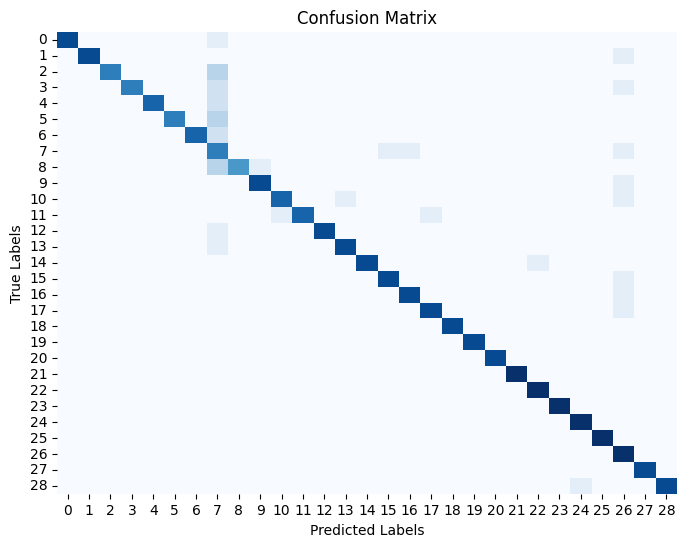

In [123]:
conf_matrix = confusion_matrix(y_test, predictions_test)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=False, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()